# Reducing and Filtering of Chord-Oddball data

In [1]:
import mne
import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "../")
import ccs_eeg_utils
import numpy as np
import pandas as pd
import mne.preprocessing as prep
import os
import sklearn 
from contextlib import contextmanager
from autoreject import AutoReject, get_rejection_threshold
import json

from mne_bids import (BIDSPath, read_raw_bids, write_raw_bids, inspect_dataset)
import auc

from mne_icalabel import label_components
from pyprep.find_noisy_channels import NoisyChannels

matplotlib.use('Qt5Agg')

%matplotlib qt

# path where dataset is stored
bids_root = "./data/ds003570/"
TASK = 'AuditoryOddballChords'
SUBJECT = '040'
SUPRESS_BIDS_OUTPUT = True
PROMPT_BADS = False
USE_ICA_JSON = False
ICA_MANUAL = False
Z_SCORE_REJECT = False
PYPREP_REJECT = True
AUTOREJECT = False

In [2]:
# Context manager to suppress stdout and stderr
@contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def read_raw_data(subject_id):
    bids_path = BIDSPath(subject=subject_id,
                         datatype='eeg', suffix='eeg', task=TASK,
                         root=bids_root)

    if SUPRESS_BIDS_OUTPUT:
        with suppress_stdout_stderr():
            raw = read_raw_bids(bids_path)
    else:
        raw = read_raw_bids(bids_path)

    # Inplace?
    ccs_eeg_utils.read_annotations_core(bids_path, raw)
    raw.load_data()
    
    return raw, bids_path

def preprocessing(raw):
    # TODO: bandpass first, downsample later? -> expensive!
    # 1. Downsampling to 128 Hz
    if raw.info['sfreq'] > 128:
        raw.resample(128)

    # Set channel types to EEG if not already set
    if not all(ch_type in ['eeg', 'stim'] for ch_type in raw.get_channel_types()):
        eeg_channel_names = raw.ch_names
        channel_types = {name: 'eeg' for name in eeg_channel_names}
        raw.set_channel_types(channel_types)

    # 2. Band-pass filter between 0.5 Hz and 30 Hz
    raw.filter(0.5, 30, fir_design='firwin')

    # 3. Re-referencing to the average activity of all electrodes
    #TODO: add apply_proj() here to apply arp?
    raw.set_eeg_reference('average', projection=True)

    """ events = prep.find_eog_events(raw)
    print(events) """

    # 5. Data Reduction (optional)
    # For instance, crop the first 60 seconds of the data

    return raw


def save_preprocessed_data(file_path, raw):
    """
    Saves the preprocessed EEG data to a file.

    Parameters:
    file_path (str): The path where the preprocessed data will be saved.
    raw (mne.io.Raw): The preprocessed MNE Raw object containing EEG data.
    """
    # Check if file_path ends with .fif extension
    if not file_path.endswith('.fif'):
        file_path += '.fif'

    # Save the data
    try:
        raw.save(file_path, overwrite=True)
        print(f"Data saved successfully to {file_path}")
    except Exception as e:
        print(f"Error saving data: {e}")

# see https://neuraldatascience.io/7-eeg/erp_artifacts.html
def get_ica(data, ica_bads, block_idx, montage):
    """
    Perform ICA on the given data. The 3 possible options are:
        1) Use the Data in the corresponding JSON File (USE_ICA_JSON=True)
        2) Label manual the components to exclude (USE_ICA_JSON=False and ICA_MANUAL=True)
        3) Automated approach using mne_icalabel (USE_ICA_JSON=False and ICA_MANUAL=False)
    Save all rejected ICA channels to ica_bads.

    Args:
        data (mne.raw): The data on which the ICA should be computed
        ica_bads (dict): datastructure to create the JSON File from
        block_idx (int): Index of the current block
        montage (mne.channels.DigMontage): Postions of the Electrodes

    Returns:
        mne.raw: Data on which ICA was performed
    """
    data.set_montage(montage)
    # Set random_state to a constant such that the ICA stays the same for multiple runs
    ica = mne.preprocessing.ICA(method="fastica", random_state=0)
  
    ica.fit(data, verbose=True)

    if USE_ICA_JSON:
        exclude_components = ica_bads[f"sub-{SUBJECT}"][block_idx]
    else:

        # Generate automated Labeling
        ic_labels = label_components(data, ica, method='iclabel')

        if ICA_MANUAL:

            # Plot Components and corresponding estimated Label      
            ica_n_components = ica.n_components_
            n_components = 64
            fig, axes = plt.subplots(nrows=7, ncols=10, figsize=(15, 10))
            axes = axes.flatten()

            for i, ax in enumerate(axes[:ica_n_components]):
                if i < n_components:
                    ica.plot_components(picks=i, show=False, axes=ax)
                    ax.text(0.5, 1, ic_labels["labels"][i], ha='center', va='center', transform=ax.transAxes)
                else:
                    ax.set_visible(False)
            plt.show(block=True)

            # User interaction
            input_str = input("Enter index of the components to be separated by space: ")

            # Converting input string to a list of integers        
            exclude_components = input_str.split()  
            exclude_components = [int(num) for num in exclude_components]  
        else:

            # Exclude all components which are not labeled as brain or other
            exclude_components = [idx for idx, label in enumerate(ic_labels["labels"]) if label not in ["brain", "other"]]
        
        # Save all components to exclude in ica_bads
        ica_bads[f"sub-{SUBJECT}"][block_idx] = exclude_components

    # Printing the list  
    print("List of components:", exclude_components) 
    ica.exclude = exclude_components
    reconst_raw = data.copy()

    # apply with excluded components
    reconst_raw = ica.apply(reconst_raw)    
    return reconst_raw


def split_in_blocks(raw):
    events, event_id = mne.events_from_annotations(raw)

    # Identify indices of 'STATUS:boundary' events
    boundary_events = events[events[:, 2] == event_id['STATUS:boundary'], 0]

    # Split the data into blocks
    blocks = []
    start_idx = 0
    for end_idx in boundary_events:
        block = raw.copy().crop(tmin=raw.times[start_idx], tmax=raw.times[end_idx])
        blocks.append(block)
        start_idx = end_idx

    block = raw.copy().crop(tmin=raw.times[start_idx])
    blocks.append(block)    

    return blocks


def mark_bad_channels_by_z_score(raw_data, threshold=8.0, window_size=10000):
    """
    Identify bad channels in raw data based on amplitude.
    Channels with z-score > threshold are marked as bad.

    Parameters:
    raw_data (mne.io.Raw): The raw data.
    threshold (float): The z-score threshold to use.

    Returns:
    list: List of bad channels.
    """
    data, times = raw_data[:, :]
    bad_channels = set()

    for start in range(0, data.shape[1], window_size):
        end = min(start + window_size, data.shape[1])
        window_data = data[:, start:end]

        channel_means = np.mean(window_data, axis=1)
        channel_stds = np.std(window_data, axis=1)
        z_scores = np.abs((window_data - channel_means[:, None]) / channel_stds[:, None])

        bad_in_window = np.where(np.any(z_scores > threshold, axis=1))[0]
        for i in bad_in_window:
            bad_channels.add(raw_data.ch_names[i])

    return list(bad_channels)


def get_epochs_from_events(data, event_str, min_reaction_s=None):
    """
    Epoch the given data based on the event_str. Exclude to fast reactions if we are in the case of a deviant event.

    Args:
        data (mne.raw): EEG Data to epoch
        event_str (string): String to determine for which event to epoch to
        min_reaction_s (float, optional): Time in seconds for the minimal reaction time at deviant events. Defaults to None.

    Returns:
        mne.Epoch: Epoch of the data for the given event
    """
    evts, evts_dict = mne.events_from_annotations(data)

    # Identify deviant events
    deviant_keys = [e for e in evts_dict.keys() if e.endswith(event_str)]
    correct_keys = [e for e in evts_dict.keys() if "STATUS:Correct - " in e]

    # Construct a dictionary of deviant events
    evts_dict_stim = {}
    for key in deviant_keys:
        evts_dict_stim[key] = evts_dict[key]

    data.info.normalize_proj()
    # Reject threshold
    reject = dict(eeg=0.0004)  # in V

    epochs = mne.Epochs(data, evts, evts_dict_stim, tmin=-0.4, tmax=1.6, baseline=(-0.4, 0), preload=True, reject=reject)

    if min_reaction_s:
        # Reconstruct which epochs where droped
        rejected_idx = []
        epoch_idx = 0

        for i, log in enumerate(epochs.drop_log):
            if len(log) == 0:
                epoch_idx += 1
            elif not log[0] == "IGNORED":
                rejected_idx.append(epoch_idx)
                epoch_idx += 1


        # Get the Labels, which where used for epoching
        d_evts = evts[evts[:, 2] == evts_dict_stim[deviant_keys[0]]]
        
        for key in deviant_keys[1:]:            
            d_evts = np.concatenate((d_evts, evts[evts[:, 2] == evts_dict_stim[key]]))
        
        # Sort events by time, to fit indexes to the indices in epochs
        d_evts = sorted(d_evts, key=lambda x: x[0])

        reaction_times = []
        i = 0
        for epoch_idx, d_evt in enumerate(d_evts):
            if not epoch_idx in rejected_idx:
                # Find the closest "Correct -" event
                c_evts = evts[np.isin(evts[:, 2], [evts_dict[key] for key in correct_keys]) & (evts[:, 0] > d_evt[0])]
                if len(c_evts) > 0:
                    # Calculate the reaction time
                    reaction_time = (c_evts[0][0] - d_evt[0]) / data.info['sfreq']  # convert to ms
                    reaction_times.append((reaction_time, key, i))
                    i += 1
        
        #Filter epochs based on reaction time
        valid_epochs = [i for (rt, _, i) in reaction_times if min_reaction_s <= rt]
        print(f"Filtered {len(valid_epochs)} epochs out of {len(epochs)} based on reaction time threshold")
        epochs = epochs[valid_epochs]

    return epochs


def interpolate_bads_and_merge(blocks):
    # Interpolate bad channels
    for block in blocks:
        block.interpolate_bads()

    # Merge the blocks
    raw = mne.concatenate_raws(blocks)

    return raw


def create_bad_json_structure():
    subjects = {}
    for s in range(1, 41):
        subject_key = f'sub-{s:03d}'
        subjects[subject_key] = {}
        for b in range(1, 9):
            block_key = f'{b}'
            subjects[subject_key][block_key] = []

    return subjects

def set_bad_channels_from_json(blocks, bad_json):
    for block in blocks:
        # Set bad channels
        block.info['bads'] = bad_json[f"sub-{SUBJECT}"][f"{blocks.index(block)+1}"]

    return blocks

In [3]:
# reduce bids eeg data
if not os.path.isfile(f"./data/processed_{SUBJECT}_raw.fif"):
    raw, bids_path = read_raw_data(SUBJECT)
    channel_types = {ch: 'eeg' for ch in raw.ch_names}
    raw.set_channel_types(channel_types)
    
    elec_data = pd.read_csv('./data/ds003570/sub-'+SUBJECT+'/eeg/sub-'+SUBJECT+'_task-AuditoryOddballChords_electrodes.tsv', sep='\t')
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_data['name'], elec_data[['x', 'y', 'z']].values)),
                                        coord_frame='head')
    raw.set_montage(montage)
    blocks = split_in_blocks(raw.copy())

    if os.path.isfile("./data/bad_channels.json"):
        bads = json.load(open("./data/bad_channels.json"))
        blocks = set_bad_channels_from_json(blocks, bads)
    else:
        bads = create_bad_json_structure()

    if os.path.isfile("./data/bad_ica_components.json"):
        ica_bads = json.load(open("./data/bad_ica_components.json"))
        #blocks = set_bad_channels_from_json(blocks, bads)
    else:
        ica_bads = create_bad_json_structure()
            
    if Z_SCORE_REJECT == True:
        for b in blocks:
            # reject by z-score (autoreject is more sophisticated, but only works on epochs)
            b.info['bads'].extend(mark_bad_channels_by_z_score(b, threshold=20.0, window_size=10000))
            print(f"Bad channels: {b.info['bads']}")
            # store? no, because determined by z-score threshold, no random component
            # bads[f"sub-{SUBJECT}"][f"{blocks.index(b)+1}"] = b.info['bads']

    if PYPREP_REJECT == True:
        for b in blocks:
            nc = NoisyChannels(b, random_state=42)
            nc.find_all_bads(ransac=False)
            b.info['bads'].extend(nc.get_bads())
            print(f"Bad channels: {b.info['bads']}")

    if PROMPT_BADS == True:
        for b in blocks:
            b.plot(n_channels=64)
            plt.show(block=True)
            bads[f"sub-{SUBJECT}"][f"{blocks.index(b)+1}"] = b.info['bads']
    
    
    with open("./data/bad_channels.json", "w") as f:
        json.dump(bads, f)

    ica_blocks = []

    for b in blocks:
        b.interpolate_bads()
        prep_block = preprocessing(b.copy())

        # ICA
        #ica_block = prep_block
        ica_block = get_ica(prep_block, ica_bads, f"{blocks.index(b)+1}", montage)
        ica_blocks.append(ica_block)
    
    with open("./data/bad_ica_components.json", "w") as f:
        json.dump(ica_bads, f)

    prep_raw = mne.concatenate_raws(ica_blocks)
    save_preprocessed_data(f"./data/processed_{SUBJECT}_raw.fif", prep_raw)

else:
    prep_raw = mne.io.read_raw_fif(f"./data/processed_{SUBJECT}_raw.fif", preload=True)

prep_raw.info

Opening raw data file ./data/processed_040_raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 299263 =      0.000 ...  2337.992 secs
Ready.
Reading 0 ... 299263  =      0.000 ...  2337.992 secs...


<Info | 13 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 line_freq: 60.0
 lowpass: 30.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: Average EEG reference: off
 sfreq: 128.0 Hz
 subject_info: 1 item (dict)
>

## Epochs

In [4]:
raw_subselect = prep_raw.copy()
raw_subselect.annotations

standard_epochs = get_epochs_from_events(raw_subselect, '_S')
exemplar_epochs = get_epochs_from_events(raw_subselect, '_deviantEcorrect_E', min_reaction_s=0.2)
function_epochs = get_epochs_from_events(raw_subselect, '_deviantFcorrect_F', min_reaction_s=0.2)

def apply_autoreject_info(epochs, autoreject_info):
    """applies the rejection thresholds and marks bad epochs from stored data"""
    threshes = autoreject_info['threshes']
    reject_log = autoreject_info['reject_log']

    # apply learned thresholds
    epochs.drop_bad(reject=threshes)

    # mark and drop bad epochs
    for i, is_bad in enumerate(reject_log):
        if is_bad:
            epochs.drop(i)

    return epochs

autoreject_file = f"./data/autoreject_info_{SUBJECT}.json"

if AUTOREJECT:
    if os.path.exists(autoreject_file):
        with open(autoreject_file, 'r') as f:
            autoreject_info = json.load(f)

        # apply autoreject results to save time
        standard_epochs_clean = apply_autoreject_info(standard_epochs, autoreject_info['standard'])
        exemplar_epochs_clean = apply_autoreject_info(exemplar_epochs, autoreject_info['exemplar'])
        function_epochs_clean = apply_autoreject_info(function_epochs, autoreject_info['function'])

    else:
        ar_standard = AutoReject()
        ar_exemplar = AutoReject()
        ar_function = AutoReject()

        # apply autoreject (takes 3-6 min)
        autoreject_info = {}

        standard_epochs_clean, reject_log_standard = ar_standard.fit_transform(standard_epochs, return_log=True)
        autoreject_info['standard'] = {
            'bad_epochs': reject_log_standard.bad_epochs,
            'reject_log': reject_log_standard.labels.tolist(),
            'threshes': ar_standard.get_reject_log(standard_epochs).threshes_
        }

        exemplar_epochs_clean, reject_log_exemplar = ar_exemplar.fit_transform(exemplar_epochs, return_log=True)
        autoreject_info['exemplar'] = {
            'bad_epochs': reject_log_exemplar.bad_epochs,
            'reject_log': reject_log_exemplar.labels.tolist(),
            'threshes': ar_exemplar.get_reject_log(exemplar_epochs).threshes_
        }

        function_epochs_clean, reject_log_function = ar_function.fit_transform(function_epochs, return_log=True)
        autoreject_info['function'] = {
            'bad_epochs': reject_log_function.bad_epochs,
            'reject_log': reject_log_function.labels.tolist(),
            'threshes': ar_function.get_reject_log(function_epochs).threshes_
        }

        # save to json per sub
        with open(autoreject_file, "w") as f:
            json.dump(autoreject_info, f, indent=4)
else:
    standard_epochs_clean = standard_epochs
    exemplar_epochs_clean = exemplar_epochs
    function_epochs_clean = function_epochs

Used Annotations descriptions: ['STATUS:16128', 'STATUS:Correct - Exemplar!', 'STATUS:Correct - Function!', 'STATUS:Incorrect - Standard!', 'STATUS:boundary', 'STATUS:five6_S', 'STATUS:five6_Sincorrect', 'STATUS:five6_deviantE', 'STATUS:five6_deviantEcorrect_E', 'STATUS:five6_deviantF', 'STATUS:five6_deviantFcorrect_F', 'STATUS:fiveRoot_S', 'STATUS:fiveRoot_Sincorrect', 'STATUS:fiveRoot_deviantE', 'STATUS:fiveRoot_deviantEcorrect_E', 'STATUS:fiveRoot_deviantF', 'STATUS:fiveRoot_deviantFcorrect_F', 'STATUS:four6_S', 'STATUS:four6_deviantE', 'STATUS:four6_deviantEcorrect_E', 'STATUS:four6_deviantF', 'STATUS:fourRoot_S', 'STATUS:fourRoot_Sincorrect', 'STATUS:fourRoot_deviantE', 'STATUS:fourRoot_deviantF', 'STATUS:fourRoot_deviantFcorrect_F', 'STATUS:one', 'STATUS:two']
Not setting metadata
1183 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 1183 events and 257 o

In [5]:
def epoch_rejection(epochs, shape):
    std_concat = np.std(epochs)

    # preallocate memory for the rejected epochs
    epochs_concat_removed = np.zeros(shape=shape)
    idx = 0  # index to keep track of the position in the pre-allocated array

    print("len prior: ", len(epochs))

    for epoch in epochs:
        for channel in epoch:
            channel_max = np.max(np.abs(channel))
            std_channel = np.std(channel)

            # apply the rejection criteria
            if channel_max < (5 * std_concat) and channel_max < (250 * 1e-6) and channel_max < (5 * std_channel):
                if idx < shape[0]:  # check to prevent index out of bounds
                    epochs_concat_removed[idx] = channel
                    idx += 1

    # truncate the array to the actual size
    epochs_concat_removed = epochs_concat_removed[:idx]

    print("len after: ", len(epochs_concat_removed))

    return epochs_concat_removed



In [6]:
# exemplar_epochs = epoch_rejection(exemplar_epochs.get_data(), np.array(exemplar_epochs.get_data()).shape)

# function_epochs = epoch_rejection(function_epochs.get_data(), np.array(function_epochs.get_data()).shape)

# standard_epochs = epoch_rejection(standard_epochs.get_data(), np.array(standard_epochs.get_data()).shape)

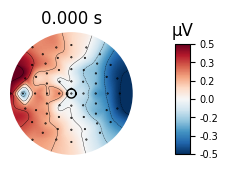

In [8]:
step = 3
window = 7

vector_values = auc.generate_forward_model_sw(standard_epochs_clean.get_data(), exemplar_epochs_clean.get_data(), [36,45], window, step)

info = raw_subselect.info
data = vector_values.reshape(-1, 1)
evoked = mne.EvokedArray(data, info)
evoked.plot_topomap(times=[0], time_unit='s', ch_type='eeg')

In [ ]:
step = 3
window = 7

roc_exemplar = auc.generate_AUC_ROC_sliding_window(standard_epochs_clean.get_data(), exemplar_epochs_clean.get_data(), window, step)
roc_function = auc.generate_AUC_ROC_sliding_window(standard_epochs_clean.get_data(), function_epochs_clean.get_data(), window, step)
time = [i*step/128 -0.4 for i in range(len(roc_exemplar))]

plt.plot(time, roc_exemplar, label="exemplar")
plt.plot(time, roc_function, label="function")
plt.axvline(-0.4, label="Chord 1")
plt.axvline(0, label="Chord 2")
plt.axvline(0.4, label="Chord 3")
plt.ylabel("AUC-Value")
plt.xlabel("Time in seconds")
plt.legend()
plt.show()


np.savetxt(f"./data/auc_roc_sl_7_3_{SUBJECT}.txt", np.column_stack((roc_exemplar, roc_function)))


In [ ]:
# roc_exemplar = generate_AUC_ROC_sliding_window(standard_epochs, exemplar_epochs, window, step)
# roc_function = generate_AUC_ROC_sliding_window(standard_epochs, function_epochs, window, step)
# time = [i*step/128 -0.4 for i in range(len(roc_exemplar))]

# plt.plot(time, roc_exemplar, label="exemplar")
# plt.plot(time, roc_function, label="function")
# plt.legend()
# plt.show()
